In [10]:
import os
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sb
import warnings
warnings.simplefilter('ignore')

In [11]:
# Print dataset file structure
def print_dir_structure(root_dir, indent=""):
    for item in os.listdir(root_dir):
        path = os.path.join(root_dir, item)
        if os.path.isdir(path):
            print(f"{indent} {item}")
            print_dir_structure(path, indent + "   ")
        else:
            print(f"{indent} {item}")

root_directory = "Dataset"
print(f" {root_directory}")
print_dir_structure(root_directory)

 Dataset
 Benign&Bruteforce
    benign
       BenignTraffic.pcap_Flow.csv
       BenignTraffic1.pcap_Flow.csv
       BenignTraffic2.pcap_Flow.csv
       BenignTraffic3.pcap_Flow.csv
    BruteForce
       DictionaryBruteForce.pcap_Flow.csv
 DDoS
    DDoS ACK Fragmentation
       DDoS-ACK_Fragmentation.pcap_Flow.csv
       DDoS-ACK_Fragmentation1.pcap_Flow.csv
       DDoS-ACK_Fragmentation10.pcap_Flow.csv
       DDoS-ACK_Fragmentation11.pcap_Flow.csv
       DDoS-ACK_Fragmentation12.pcap_Flow.csv
       DDoS-ACK_Fragmentation2.pcap_Flow.csv
       DDoS-ACK_Fragmentation3.pcap_Flow.csv
       DDoS-ACK_Fragmentation4.pcap_Flow.csv
       DDoS-ACK_Fragmentation5.pcap_Flow.csv
       DDoS-ACK_Fragmentation6.pcap_Flow.csv
       DDoS-ACK_Fragmentation7.pcap_Flow.csv
       DDoS-ACK_Fragmentation8.pcap_Flow.csv
       DDoS-ACK_Fragmentation9.pcap_Flow.csv
    DDoS ICMP Flood
       DDoS-ICMP_Flood.pcap_Flow.csv
       DDoS-ICMP_Flood1.pcap_Flow.csv
       DDoS-ICMP_Flood10.pcap_Flow.csv
       

In [12]:
root_dir = "Dataset"
data_list = []
column_names = None

for category_folder in os.listdir(root_dir):
    category_path = os.path.join(root_dir, category_folder)

    if os.path.isdir(category_path):
        found_csv = False

        csv_files = [f for f in os.listdir(category_path) if f.endswith('.csv')]
        if csv_files:
            found_csv = True
            for csv_file in csv_files:
                csv_path = os.path.join(category_path, csv_file)
                df = pd.read_csv(csv_path)

                if column_names is None:
                    column_names = df.columns.tolist()
                else:
                    df.columns = column_names

                df["Target"] = category_folder
                data_list.append(df)

        if not found_csv:
            for sub_folder in os.listdir(category_path):
                sub_folder_path = os.path.join(category_path, sub_folder)

                if os.path.isdir(sub_folder_path):
                    csv_files = [f for f in os.listdir(sub_folder_path) if f.endswith('.csv')]
                    if csv_files:
                        csv_path = os.path.join(sub_folder_path, csv_files[0])
                        df = pd.read_csv(csv_path)

                        if column_names is None:
                            column_names = df.columns.tolist()
                        else:
                            df.columns = column_names

                        df["Target"] = sub_folder
                        data_list.append(df)

merged_df = pd.concat(data_list, ignore_index=True)
merged_df = merged_df.drop(['Label'], axis=1)
merged_df.head()

,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Total Fwd Packet,Total Bwd packets,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Target
0,192.168.137.41-157.249.81.141-51746-80-6,192.168.137.41,51746,157.249.81.141,80,6,07/10/2022 02:15:01 PM,291959,5,4,...,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,benign
1,192.168.137.41-157.249.81.141-50096-443-6,192.168.137.41,50096,157.249.81.141,443,6,07/10/2022 02:15:01 PM,291320,5,4,...,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,benign
2,192.168.137.41-157.249.81.141-51749-80-6,192.168.137.41,51749,157.249.81.141,80,6,07/10/2022 02:15:03 PM,292739,5,4,...,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,benign
3,192.168.137.41-157.249.81.141-50099-443-6,192.168.137.41,50099,157.249.81.141,443,6,07/10/2022 02:15:03 PM,292398,5,4,...,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,benign
4,192.168.137.41-157.249.81.141-51752-80-6,192.168.137.41,51752,157.249.81.141,80,6,07/10/2022 02:15:04 PM,293252,5,4,...,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,benign


In [13]:
merged_df['Target'].value_counts()

Target
DoS SYN Flood              3990181
DoS-UDP_Flood               934001
DoS-HTTP_Flood              932513
DDoS-HTTP Flood             505720
VulnerabilityScan           442158
DDoS ACK Fragmentation      323886
benign                      183630
Mirai                       174588
DNS Spoofing                 74856
ARP Spoofing                 73033
DDoS-ICMP_Fragmentation      14479
DDoS ICMP Flood              10415
sqlinjection                  6603
BruteForce                    3619
XSS                           3377
Uploading_Attack              1348
Name: count, dtype: int64

In [15]:
# Replace the labels
label_mapping = {
    "DDoS ACK Fragmentation": "DDoS",
    "DDoS ICMP Flood": "DDoS",
    "DDoS-HTTP Flood": "DDoS",
    "DDoS-ICMP_Fragmentation": "DDoS",
    "ARP Spoofing": "Spoofing",
    "DNS Spoofing": "Spoofing",
    "DoS SYN Flood": "DoS",
    "DoS-TCP_Flood": "DoS",
    "DoS-HTTP_Flood": "DoS",
    "DoS-UDP_Flood": "DoS"
}
merged_df["Target"] = merged_df["Target"].replace(label_mapping)
merged_df['Target'].value_counts()

Target
DoS                  5856695
DDoS                  854500
VulnerabilityScan     442158
benign                183630
Mirai                 174588
Spoofing              147889
sqlinjection            6603
BruteForce              3619
XSS                     3377
Uploading_Attack        1348
Name: count, dtype: int64

<Axes: title={'center': 'Attack Type Distribution'}>

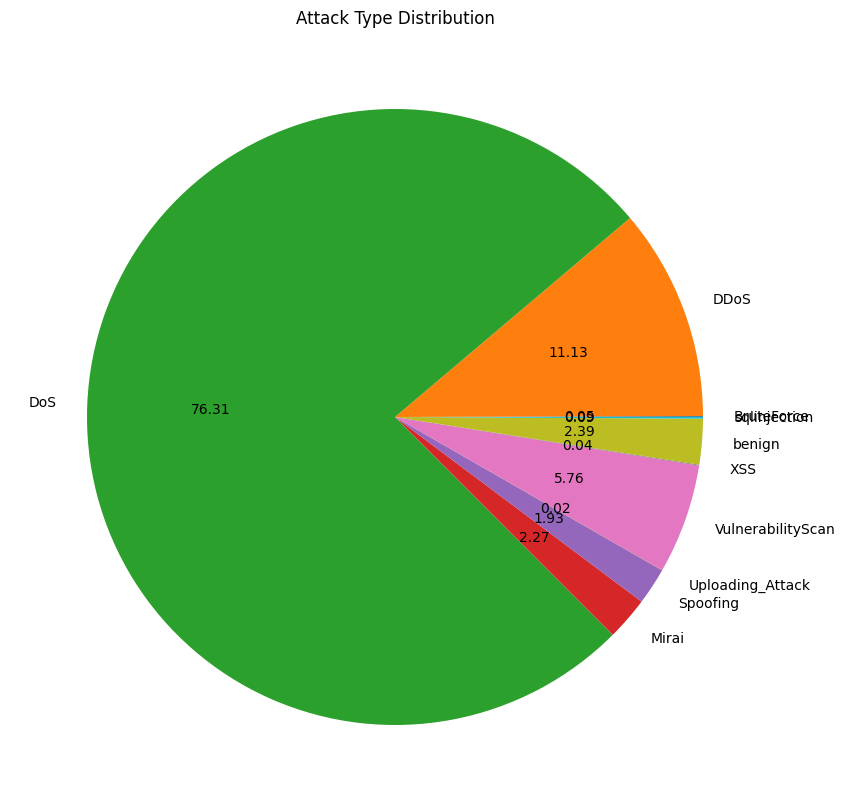

In [17]:
# Show the targets distribution
plt.title("Attack Type Distribution")
merged_df.groupby('Target').size().plot(kind='pie', autopct='%.2f', figsize=(10,10))